<a id='1'></a>
# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split


from PIL import Image,ImageEnhance
import random

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id='2'></a>
# Data Augmentation

In [2]:
root_dir="/kaggle/input/brain-mri-images-for-brain-tumor-detection/"

In [3]:
os.makedirs("/kaggle/working/data-augmentation")
os.makedirs('/kaggle/working/data-augmentation/yes')  
os.makedirs('/kaggle/working/data-augmentation/no')

In [4]:
def data_augmentation(input_dir,output_dir,image_num_no=5,image_num_yes=8):
    
    for files in listdir(input_dir):
        for file in listdir(input_dir+files):
            if(file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
                input_path=os.path.join(input_dir+files,file)
                image=Image.open(input_path).convert("L")
                
                if(files=="no"):
                    for i in range(image_num_no):
                        augmented_image=apply_augmentation(image)
                        output_file=f"{os.path.splitext(file)[0]}_{i}.png"
                        output_path=os.path.join(output_dir+files,output_file)
                        augmented_image.save(output_path)
                        
                elif(files=="yes"):
                    for i in range(image_num_yes):
                        augmented_image = apply_augmentation(image)
                        output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                        output_path = os.path.join(output_dir+files, output_file)
                        augmented_image.save(output_path)

In [5]:
def apply_augmentation(image):
    
    angle=random.randint(-10,10)
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    
    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))
    
    # nearest-neighbor
    
    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))
    
    new_image=color_image.resize(new_size,Image.NEAREST)
    
    
    return new_image

In [6]:
input_dir="/kaggle/input/brain-mri-images-for-brain-tumor-detection/"
output_dir="/kaggle/working/data-augmentation/"

data_augmentation(input_dir=input_dir,output_dir=output_dir,image_num_no=5,image_num_yes=5)

print("Number of photos named 'yes' :",len(listdir("/kaggle/working/data-augmentation/yes")))
print("Number of photos named 'no' :",len(listdir("/kaggle/working/data-augmentation/no")))

Number of photos named 'yes' : 430
Number of photos named 'no' : 460


<a id='3'></a>
# Loading Data

In [9]:
class CustomDataset(Dataset):
    
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        
        self.images=[]
        self.labels=[]
        
        for subdir,_,files in os.walk(root_dir):
            for file in files:
                if(file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
                    self.images.append(os.path.join(subdir,file))
                    
                    label=1 if "yes" in subdir else 0
                    self.labels.append(label)
                    
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image_path=self.images[idx]
        image=Image.open(image_path).convert("L")
        
        if(self.transform):
            image=self.transform(image)
            
        label=self.labels[idx]
        
        return image,label

In [10]:
transform=transforms.Compose([transforms.Resize((240,240)),
                              transforms.ToTensor(),
                               transforms.Normalize([0.485],[0.229])
                              ])

root_dir="/kaggle/working/data-augmentation/"
train_test_dataset=CustomDataset(root_dir=root_dir,transform=transform)

Splitting Data

In [11]:
train_size=0.7
test_size=0.15
valid_size=1-(train_size+test_size)

total_data=len(train_test_dataset)
indices=list(range(total_data))

train_indices, test_indices = train_test_split(indices, test_size=(test_size + valid_size),random_state=42)
test_indices, valid_indices = train_test_split(test_indices, test_size=(valid_size / (test_size + valid_size)),random_state=42)

print(" Number of train indices:{}\n Number of test indices:{}\n Number of validation indices:{}".format(len(train_indices),len(test_indices),len(valid_indices)))

train_dataset=torch.utils.data.Subset(train_test_dataset,train_indices)
test_dataset=torch.utils.data.Subset(train_test_dataset,test_indices)
valid_dataset=torch.utils.data.Subset(train_test_dataset,valid_indices)

batch_size = 32 

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size)

 Number of train indices:622
 Number of test indices:134
 Number of validation indices:134


<a id='4'></a>
# Data Visualization

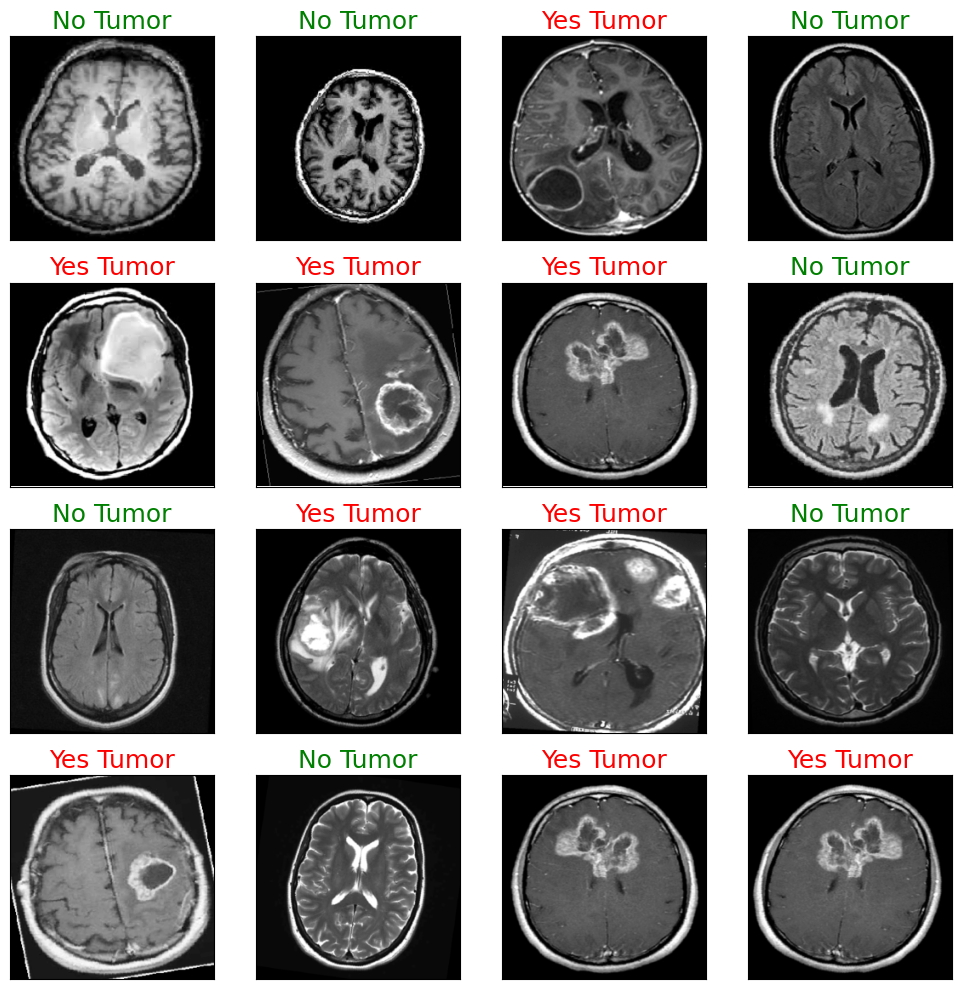

In [12]:
data_iter=iter(train_loader)
images,labels=next(data_iter)

images=images.numpy()

iteration=16

fig=plt.figure(figsize=(10,10))

for index in np.arange(iteration):
    
    ax=fig.add_subplot(4,int(iteration/4),index+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[index]),cmap="gray")
    ax.set_title("No Tumor" if str(labels[index])[-2]=="0" else "Yes Tumor",fontsize=18, color="green" if str(labels[index])[-2]=="0" else "red")
    
    
plt.tight_layout()

<a id='5'></a>
# Creating ResNet Architecture

In [13]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        

        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)

        return out

In [14]:
class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        
        out = self.relu(out)

        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



In [16]:
def ResNet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def ResNet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def ResNet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

def ResNet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

def ResNet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

<a id='6'></a>
# Model Training

In [17]:
def train(model,train_loader,optimizer,criteron):
    
    model.train()
    train_loss=0
    correct=0
    total=0
    
    for images,labels in train_loader:
        images,labels =images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()
        
    train_accuracy=100*correct/total
    train_loss/=len(train_loader)
    return train_loss,train_accuracy

In [18]:
def validate(model,valid_loader,criterion):
    model.eval()
    val_loss=0
    correct=0
    total=0
    
    with torch.no_grad():
        for images,labels in valid_loader:
            images,labels=images.to(device),labels.to(device)
            
            outputs=model(images)
            loss=criterion(outputs,labels)
            
            val_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
            
        val_accuracy = 100.0 * correct / total
        val_loss /= len(valid_loader)
    return val_loss, val_accuracy

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet18 = ResNet18(num_classes=2).to(device)
resnet34 = ResNet34(num_classes=2).to(device)
resnet50 = ResNet50(num_classes=2).to(device)
resnet101 = ResNet101(num_classes=2).to(device)
resnet152 = ResNet152(num_classes=2).to(device)


epochs = 25
criterion = nn.CrossEntropyLoss()

optimizer18 = optim.Adam(resnet18.parameters(),lr=1e-4)
optimizer34 = optim.Adam(resnet34.parameters(),lr=1e-3)
optimizer50 = optim.Adam(resnet50.parameters(),lr=1e-3)
optimizer101 = optim.Adam(resnet101.parameters(),lr=1e-3)
optimizer152 = optim.Adam(resnet152.parameters(),lr=1e-3)

models={"resnet18":resnet18,"resnet34":resnet34,"resnet50":resnet50,"resnet101":resnet101,"resnet152":resnet152}
optimizers = {"resnet18": optimizer18, "resnet34": optimizer34, "resnet50": optimizer50, "resnet101": optimizer101, "resnet152": optimizer152}

In [20]:
import pandas as pd
models_result=pd.DataFrame(index=["resnet18","resnet34","resnet50","resnet101","resnet152"],columns=["train_accuracy","validation_accuracy","train_losses","validation_losses"])
models_result.head()

,train_accuracy,validation_accuracy,train_losses,validation_losses
resnet18,NaN,NaN,NaN,NaN
resnet34,NaN,NaN,NaN,NaN
resnet50,NaN,NaN,NaN,NaN
resnet101,NaN,NaN,NaN,NaN
resnet152,NaN,NaN,NaN,NaN


In [21]:
for key,models_name in models.items():
    optimizer = optimizers[key]
    
    train_accuracy=list()
    validation_accuracy=list()
    train_losses=list()
    validation_losses=list()
    
    print(key+" model started training")
    for epoch in range(epochs):
        
        train_loss, train_acc = train(models_name, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(models_name, valid_loader, criterion)
        
        
        train_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)


        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")
    
    print(key+" model finished training"+"\n\n")
    
    
    train_accuracy_float = list(map(float, train_accuracy))
    validation_accuracy_float = list(map(float, validation_accuracy))
    train_losses_float = list(map(float, train_losses))
    validation_losses_float = list(map(float, validation_losses))
    
    models_result.loc[key,"train_accuracy"]=train_accuracy_float
    models_result.loc[key,"validation_accuracy"]=validation_accuracy_float
    models_result.loc[key,"train_losses"]=train_losses_float
    models_result.loc[key,"validation_losses"]=validation_losses_float
    
    
    torch.save(models_name.state_dict(), "{}_model.pth".format(key))
    del models_name
    torch.cuda.empty_cache()

resnet18 model started training
Epoch 1/25: Train Loss: 0.5064, Validation Loss: 0.8893 Train Accuracy: 76.05%, Validation Accuracy: 52.24%
Epoch 2/25: Train Loss: 0.1573, Validation Loss: 0.5660 Train Accuracy: 95.34%, Validation Accuracy: 73.88%
Epoch 3/25: Train Loss: 0.0425, Validation Loss: 0.7905 Train Accuracy: 98.55%, Validation Accuracy: 70.15%
Epoch 4/25: Train Loss: 0.0548, Validation Loss: 0.1597 Train Accuracy: 98.71%, Validation Accuracy: 91.04%
Epoch 5/25: Train Loss: 0.0448, Validation Loss: 0.4542 Train Accuracy: 98.55%, Validation Accuracy: 83.58%
Epoch 6/25: Train Loss: 0.0385, Validation Loss: 0.1464 Train Accuracy: 98.23%, Validation Accuracy: 91.79%
Epoch 7/25: Train Loss: 0.0420, Validation Loss: 0.4113 Train Accuracy: 98.55%, Validation Accuracy: 86.57%
Epoch 8/25: Train Loss: 0.0139, Validation Loss: 0.4852 Train Accuracy: 99.68%, Validation Accuracy: 88.06%
Epoch 9/25: Train Loss: 0.0107, Validation Loss: 0.1584 Train Accuracy: 99.52%, Validation Accuracy: 93.

In [22]:
models_result

,train_accuracy,validation_accuracy,train_losses,validation_losses
resnet18,"[76.04501607717042, 95.33762057877813, 98.5530...","[52.23880597014925, 73.88059701492537, 70.1492...","[0.5064432442188262, 0.15728583047166467, 0.04...","[0.8892893671989441, 0.5660271257162094, 0.790..."
resnet34,"[62.057877813504824, 77.65273311897106, 78.456...","[52.985074626865675, 82.08955223880596, 86.567...","[0.8341047450900078, 0.4720777362585068, 0.463...","[9.736368942260743, 0.5799428999423981, 0.4254..."
resnet50,"[64.14790996784566, 74.27652733118971, 75.8842...","[47.76119402985075, 73.88059701492537, 72.3880...","[1.0455622494220733, 0.6126070156693458, 0.521...","[1.4853758573532105, 0.5724394083023071, 0.522..."
resnet101,"[61.09324758842444, 75.88424437299035, 78.4565...","[64.17910447761194, 79.85074626865672, 63.4328...","[1.0389227032661439, 0.5055123046040535, 0.452...","[0.6437076330184937, 0.5519035756587982, 0.704..."
resnet152,"[54.5016077170418, 62.861736334405144, 66.0771...","[74.6268656716418, 58.208955223880594, 78.3582...","[1.1554559737443924, 0.6923257857561111, 0.634...","[0.596185839176178, 0.6721021890640259, 0.5474..."


<a id='7'></a>
# Visualizing the Results of the ResNet-18 Model

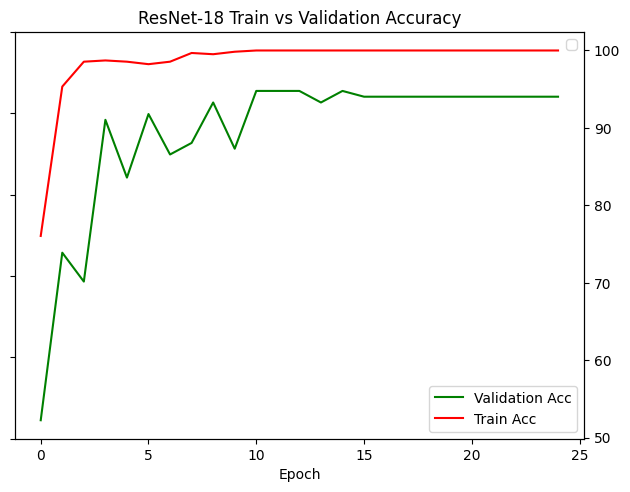

In [23]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet18","validation_accuracy"]),label = "Validation Acc",color="green")
ax2.plot(np.array(models_result.loc["resnet18","train_accuracy"]),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])


fig.tight_layout()
plt.title("ResNet-18 Train vs Validation Accuracy")
plt.show()

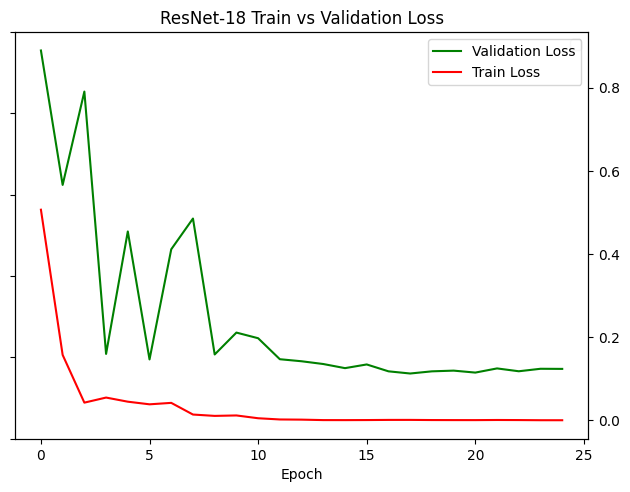

In [24]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet18","validation_losses"]),label = "Validation Loss",color="green")
ax2.plot(np.array(models_result.loc["resnet18","train_losses"]),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("ResNet-18 Train vs Validation Loss")
plt.show()

In [25]:
resnet18.load_state_dict(torch.load("/kaggle/working/resnet18_model.pth"))
predictions=[]
actual_labels=[]

resnet18.eval()

with torch.no_grad():
    for images,labels in test_loader:        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs=resnet18(images)
        
        _,predicted=torch.max(outputs,1)
        
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
129,1,1
130,1,1
131,1,1
132,1,1


In [26]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score: {accuracy}")

Total number of correct predictions: 126
Accuracy Score: 0.9402985074626866


<Axes: >

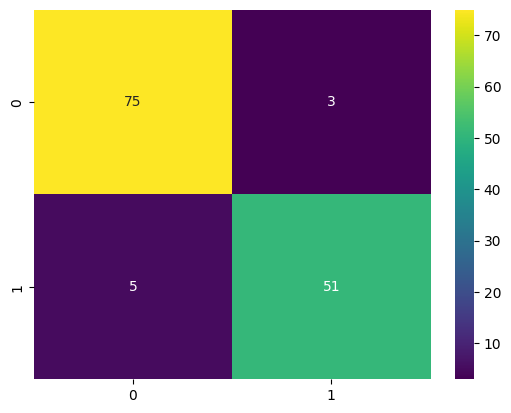

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')

<a id='8'></a>
# Visualizing the Results of the ResNet-34 Model

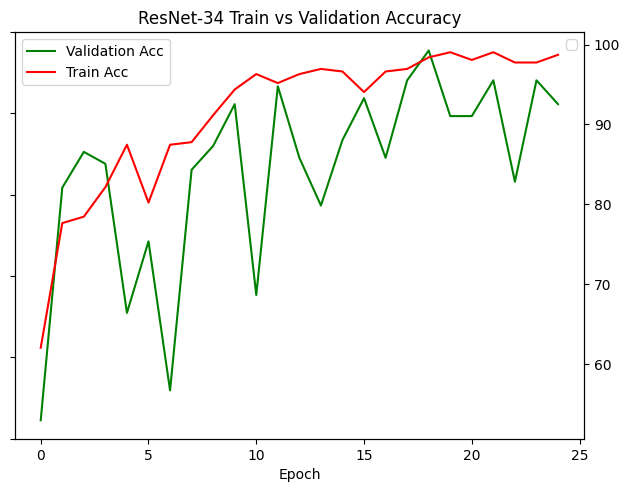

In [28]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet34","validation_accuracy"]),label = "Validation Acc",color="green")
ax2.plot(np.array(models_result.loc["resnet34","train_accuracy"]),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])


fig.tight_layout()
plt.title("ResNet-34 Train vs Validation Accuracy")
plt.show()

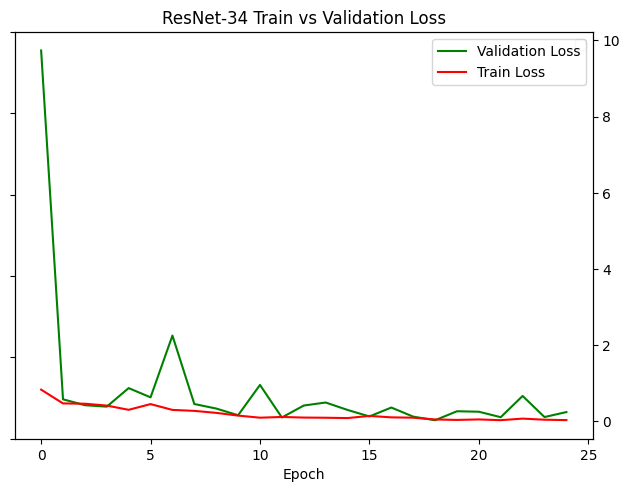

In [29]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet34","validation_losses"]),label = "Validation Loss",color="green")
ax2.plot(np.array(models_result.loc["resnet34","train_losses"]),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("ResNet-34 Train vs Validation Loss")
plt.show()

In [30]:
resnet34.load_state_dict(torch.load("/kaggle/working/resnet34_model.pth"))
predictions=[]
actual_labels=[]

resnet34.eval()

with torch.no_grad():
    for images,labels in test_loader:        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs=resnet34(images)
        
        _,predicted=torch.max(outputs,1)
        
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
129,1,1
130,1,1
131,1,1
132,1,1


In [31]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score: {accuracy}")

Total number of correct predictions: 124
Accuracy Score: 0.9253731343283582


<Axes: >

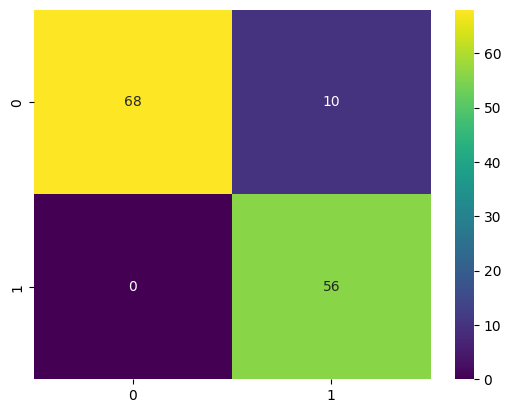

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')

<a id='9'></a>
# Visualizing the Results of the ResNet-50 Model

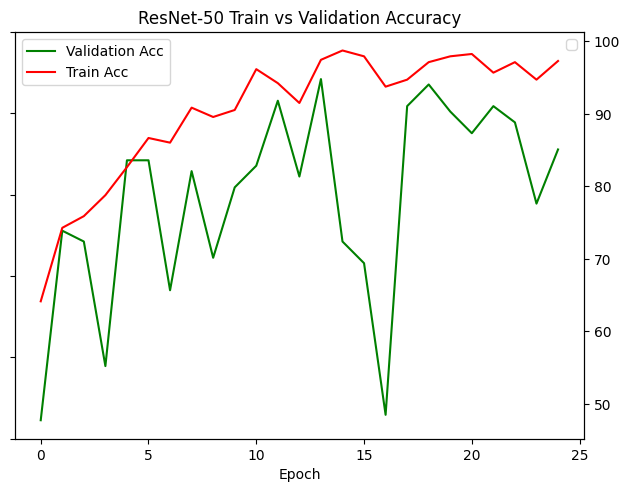

In [33]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet50","validation_accuracy"]),label = "Validation Acc",color="green")
ax2.plot(np.array(models_result.loc["resnet50","train_accuracy"]),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])


fig.tight_layout()
plt.title("ResNet-50 Train vs Validation Accuracy")
plt.show()

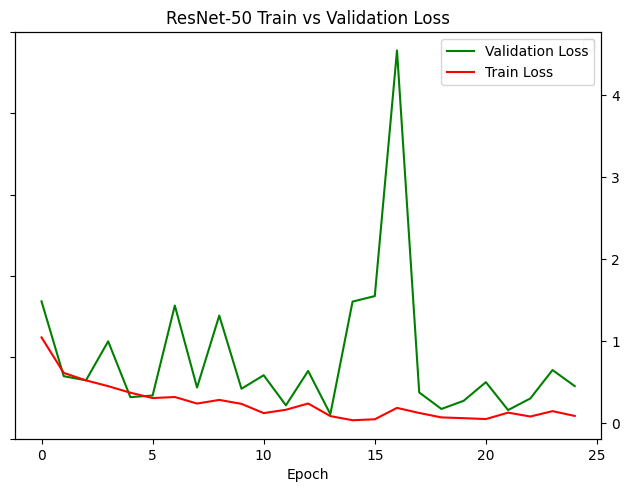

In [34]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet50","validation_losses"]),label = "Validation Loss",color="green")
ax2.plot(np.array(models_result.loc["resnet50","train_losses"]),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("ResNet-50 Train vs Validation Loss")
plt.show()

In [35]:
resnet50.load_state_dict(torch.load("/kaggle/working/resnet50_model.pth"))
predictions=[]
actual_labels=[]

resnet50.eval()

with torch.no_grad():
    for images,labels in test_loader:        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs=resnet50(images)
        
        _,predicted=torch.max(outputs,1)
        
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,1
4,1,1
...,...,...
129,1,1
130,1,1
131,1,1
132,1,1


In [36]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score: {accuracy}")

Total number of correct predictions: 122
Accuracy Score: 0.9104477611940298


<Axes: >

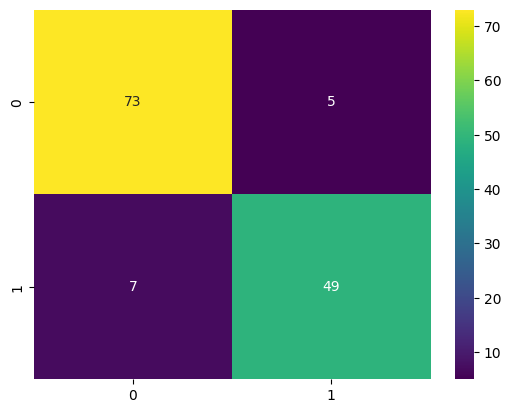

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')

<a id='10'></a>
# Visualizing the Results of the ResNet-101 Model

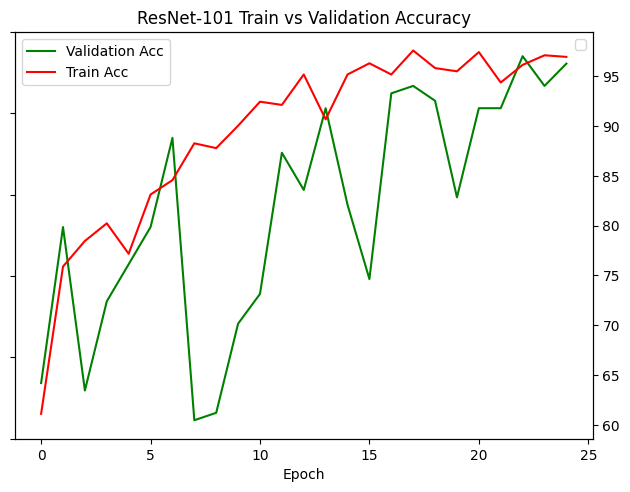

In [38]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet101","validation_accuracy"]),label = "Validation Acc",color="green")
ax2.plot(np.array(models_result.loc["resnet101","train_accuracy"]),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])


fig.tight_layout()
plt.title("ResNet-101 Train vs Validation Accuracy")
plt.show()

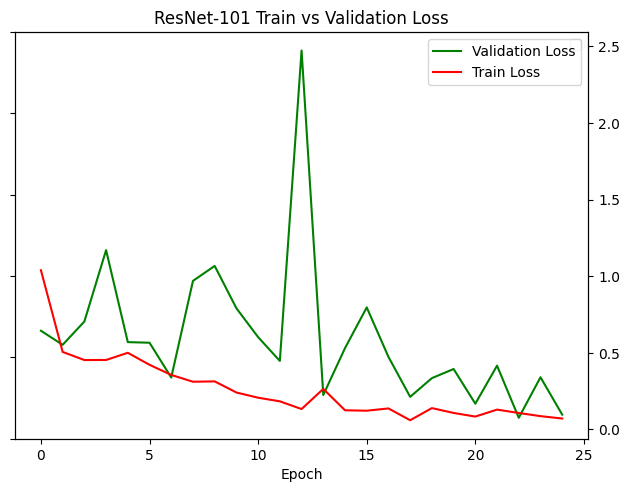

In [39]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet101","validation_losses"]),label = "Validation Loss",color="green")
ax2.plot(np.array(models_result.loc["resnet101","train_losses"]),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("ResNet-101 Train vs Validation Loss")
plt.show()

In [40]:
resnet101.load_state_dict(torch.load("/kaggle/working/resnet101_model.pth"))
predictions=[]
actual_labels=[]

resnet101.eval()

with torch.no_grad():
    for images,labels in test_loader:        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs=resnet101(images)
        
        _,predicted=torch.max(outputs,1)
        
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
129,1,1
130,1,1
131,1,1
132,1,1


In [41]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score: {accuracy}")

Total number of correct predictions: 125
Accuracy Score: 0.9328358208955224


<Axes: >

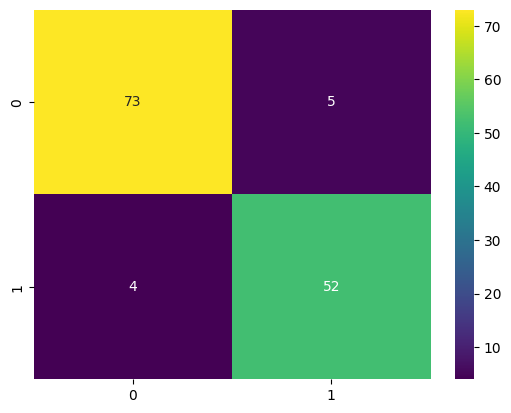

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')

<a id='11'></a>
# Visualizing the Results of the ResNet-152 Model

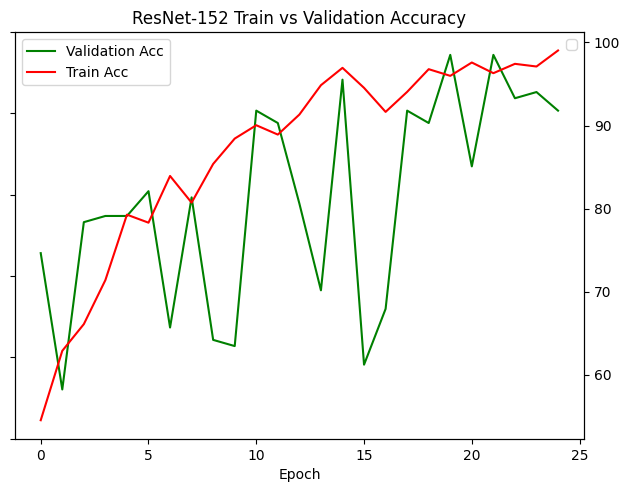

In [43]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet152","validation_accuracy"]),label = "Validation Acc",color="green")
ax2.plot(np.array(models_result.loc["resnet152","train_accuracy"]),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])


fig.tight_layout()
plt.title("ResNet-152 Train vs Validation Accuracy")
plt.show()

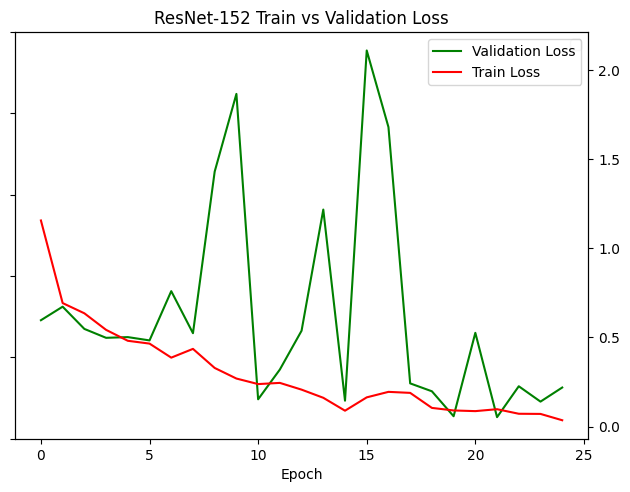

In [44]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax2.plot(np.array(models_result.loc["resnet152","validation_losses"]),label = "Validation Loss",color="green")
ax2.plot(np.array(models_result.loc["resnet152","train_losses"]),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("ResNet-152 Train vs Validation Loss")
plt.show()

In [45]:
resnet152.load_state_dict(torch.load("/kaggle/working/resnet152_model.pth"))
predictions=[]
actual_labels=[]

resnet152.eval()

with torch.no_grad():
    for images,labels in test_loader:        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs=resnet152(images)
        
        _,predicted=torch.max(outputs,1)
        
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())
        
results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
129,1,1
130,1,1
131,1,1
132,1,1


In [46]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score: {accuracy}")

Total number of correct predictions: 127
Accuracy Score: 0.9477611940298507


<Axes: >

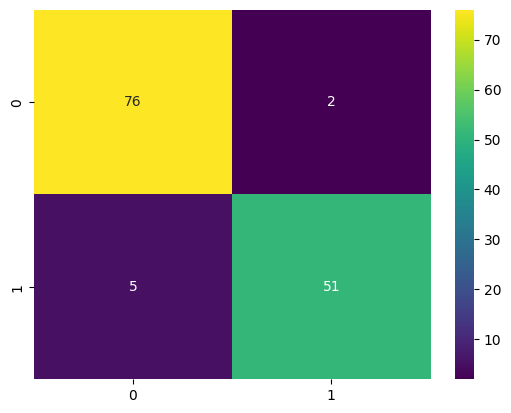

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')